#Цель и задачи

**Целью** моей работы будет определение перспективности отрасли строительства путем расчета и анализа экономических метрик для средних и малых строительных компаний.

**Задачи:**

*   Проанализировать исходный датасет
*   Спарсить необходимые показатели с сайта Федеральной Налоговой Службы
*   На основе собранной статистики посчитать метрики
*   Построить графики и сделать выводы



#Установка необходимых библиотек

In [ ]:
pip install geopy

In [ ]:
pip install geopandas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import plotly.express as px
from geopy.geocoders import Nominatim
import geopandas as gpd
import time
from shapely.geometry import Point

#Загрузка и обработка датасета

In [ ]:
registry = pd.read_excel("Реестр.xlsx")

E:\anaconda\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
registry = registry.drop(0).reset_index(drop=True)

In [ ]:
registry.columns = registry.iloc[0]
registry = registry.drop(0).reset_index(drop=True)

In [ ]:
registry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603520 entries, 0 to 603519
Data columns (total 23 columns):
 #   Column                                                                    Non-Null Count   Dtype 
---  ------                                                                    --------------   ----- 
 0   № п/п                                                                     603520 non-null  object
 1   Наименование / ФИО                                                        603520 non-null  object
 2   Тип субъекта                                                              603520 non-null  object
 3   Категория                                                                 603520 non-null  object
 4   ОГРН                                                                      603520 non-null  object
 5   ИНН                                                                       603520 non-null  object
 6   Основной вид деятельности                                   

In [ ]:
registry.head(5)

,№ п/п,Наименование / ФИО,Тип субъекта,Категория,ОГРН,ИНН,Основной вид деятельности,Регион,Район,Город,...,Дата исключения из реестра,Телефон,E-mail,WWW,Наличие лицензий,"Наличие заключенных договоров, контрактов","Производство инновационной, высокотехнологичной продукции",Участие в программах партнерства,Является социальным предприятием,Среднесписочная численность работников за предшествующий календарный год
0,1,""" МЕГАПОЛИС "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВ...",Юридическое лицо,Не является субъектом МСП,1027800523376,7801190028,41.2 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN,NaN,...,10.10.2021,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN
1,2,""" СТАЛЬИНВЕСТСТРОЙ "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ О...",Юридическое лицо,Не является субъектом МСП,1037800033545,7801227976,41.20 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN,NaN,...,10.08.2018,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN
2,3,""" СТРОЙТЕХНИКА - М "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ О...",Юридическое лицо,Не является субъектом МСП,1025204418293,5263039399,41.20 Строительство жилых и нежилых зданий,52 - Нижегородская область,NaN,г Нижний Новгород,...,10.07.2022,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN
3,4,"""БАЗИС"" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ",Юридическое лицо,Микропредприятие,1025204411682,5263025484,41.20 Строительство жилых и нежилых зданий,52 - Нижегородская область,NaN,г Нижний Новгород,...,NaN,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,1
4,5,"""БЕЛАГ"" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ",Юридическое лицо,Не является субъектом МСП,1037800039276,7801123215,41.20 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN,NaN,...,10.07.2021,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN


#Фильтрация датасета

In [ ]:
filter = (
    (registry["Категория"].isin(["Малое предприятие", "Среднее предприятие"])) &
    (registry["Тип субъекта"] == "Юридическое лицо") &
    (registry["Основной вид деятельности"] == "41.20 Строительство жилых и нежилых зданий")
)

filtered_registry = registry[filter].reset_index(drop=True)

In [ ]:
filtered_registry

,№ п/п,Наименование / ФИО,Тип субъекта,Категория,ОГРН,ИНН,Основной вид деятельности,Регион,Район,Город,...,Дата исключения из реестра,Телефон,E-mail,WWW,Наличие лицензий,"Наличие заключенных договоров, контрактов","Производство инновационной, высокотехнологичной продукции",Участие в программах партнерства,Является социальным предприятием,Среднесписочная численность работников за предшествующий календарный год
0,20,"""КОРПОРАЦИЯ ВИТ"" (ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕ...",Юридическое лицо,Малое предприятие,1025004907080,5038038838,41.20 Строительство жилых и нежилых зданий,50 - Московская область,Пушкино г,NaN,...,NaN,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,36
1,52,"""ХОЗРАСЧЕТНАЯ СТРОИТЕЛЬНО-ТЕХНОЛОГИЧЕСКАЯ ФИРМ...",Юридическое лицо,Среднее предприятие,1025007270551,5027006369,41.20 Строительство жилых и нежилых зданий,50 - Московская область,NaN,г Дзержинский,...,NaN,NaN,NaN,NaN,Да,Нет,Нет,Нет,Нет,201
2,4653,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""777""",Юридическое лицо,Малое предприятие,1021400692048,1414006922,41.20 Строительство жилых и нежилых зданий,77 - г.Москва,NaN,NaN,...,NaN,NaN,NaN,NaN,Да,Нет,Нет,Нет,Нет,35
3,4668,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АГРОТЕХИМПОРТ""",Юридическое лицо,Малое предприятие,1043301806415,3327332190,41.20 Строительство жилых и нежилых зданий,33 - Владимирская область,NaN,г Владимир,...,NaN,NaN,NaN,NaN,Да,Нет,Нет,Нет,Нет,52
4,4674,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АКС""",Юридическое лицо,Малое предприятие,1027807999988,7816061297,41.20 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN,NaN,...,NaN,NaN,NaN,NaN,Да,Нет,Нет,Нет,Нет,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8922,560512,"СМУ ""МОНОЛИТ"" (ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТ...",Юридическое лицо,Малое предприятие,1162301050515,2301091157,41.20 Строительство жилых и нежилых зданий,23 - Краснодарский край,Анапский р-н,г Анапа,...,NaN,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,4
8923,560513,"СМУ ""РУСЬ"" (ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕН...",Юридическое лицо,Малое предприятие,1132301002900,2301083597,41.20 Строительство жилых и нежилых зданий,23 - Краснодарский край,Анапский р-н,г Анапа,...,NaN,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,74
8924,560903,СОВМЕСТНОЕ ПРЕДПРИЯТИЕ ОБЩЕСТВО С ОГРАНИЧЕННОЙ...,Юридическое лицо,Среднее предприятие,1026500785673,6504043928,41.20 Строительство жилых и нежилых зданий,65 - Сахалинская область,Корсаковский р-н,г Корсаков,...,NaN,NaN,NaN,NaN,Да,Нет,Нет,Нет,Нет,145
8925,580133,"ФИРМА ""ТЕПЛОСТРОЙПРОЕКТ-С"" ОБЩЕСТВО С ОГРАНИЧЕ...",Юридическое лицо,Малое предприятие,1032000400233,2002001476,41.20 Строительство жилых и нежилых зданий,20 - Чеченская Республика,Ачхой-Мартановский р-н,NaN,...,NaN,NaN,NaN,NaN,Да,Нет,Нет,Нет,Нет,67


#Парсинг необходимых показателей

In [ ]:
def get_information_from_json(request):
    years_mas = []
    income_mas = []
    clean_income_mas = []
    ebitda_mas = []
    for j in range(len(request)):
        year = request[j]["period"]
        clean_income = request[j]["correction"]["financialResult"]["current2400"]
        try:
          income = request[j]["correction"]["financialResult"]["current2110"]
        except:
          income = 0
        try:
          tax = abs(request[j]["correction"]["financialResult"]["current2410"])
        except:
          tax = 0
        try:
          procent = abs(request[j]["correction"]["financialResult"]["current2330"])
        except:
          procent = 0
        ebitda = clean_income + tax + procent
        years_mas.append(year)
        income_mas.append(income)
        clean_income_mas.append(clean_income)
        ebitda_mas.append(ebitda)
    return years_mas, income_mas, clean_income_mas, ebitda_mas

In [ ]:
headers ={'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.28 Safari/537.36'}
session = requests.Session()
session.headers = headers
all_inn = filtered_registry["ИНН"].to_list()
sum_ebitda_per_year = {"2019": 0, "2020": 0, "2021": 0, "2022": 0, "2023": 0}
count_ebitda_per_year = {"2019": 0, "2020": 0, "2021": 0, "2022": 0, "2023": 0}
increase_between_2022_2023 = np.array([])
income_in_2023 = []
for i, inn in enumerate(all_inn):
      try:
        res = session.get(f"https://bo.nalog.ru/advanced-search/organizations/search?query={int(inn)}&page=0").json()
        company_id = res["content"][0]["id"]
        res = session.get(f"https://bo.nalog.ru/nbo/organizations/{company_id}/bfo/").json()
        years_mas, income_mas, clean_income_mas, ebitda_mas = get_information_from_json(res)
        for j in range(len(years_mas)):
          sum_ebitda_per_year[years_mas[j]] += ebitda_mas[j]
          count_ebitda_per_year[years_mas[j]] += 1
        if "2022" in years_mas and "2023" in years_mas:
            increase_between_2022_2023 = np.append(increase_between_2022_2023,[round(((clean_income_mas[years_mas.index("2023")] - clean_income_mas[years_mas.index("2022")])/clean_income_mas[years_mas.index("2022")])*100)])
        income_in_2023.append([income_mas[years_mas.index("2023")], i])
      except:
        ...
print(sum_ebitda_per_year)
print(count_ebitda_per_year)

{'2019': 86452733.0, '2020': 98911922.0, '2021': 109004468.0, '2022': 131707974.0, '2023': 160206941.0}
{'2019': 7743, '2020': 7960, '2021': 8149, '2022': 8440, '2023': 7976}


#Построение графиков

##Средняя EBITDA по годам

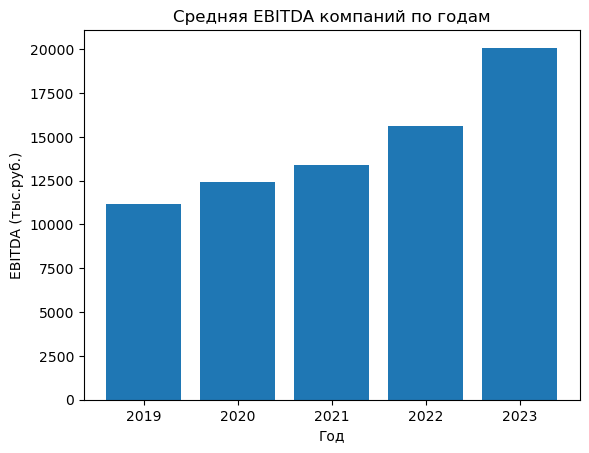

In [ ]:
mean_ebitda_per_year = {}
for year in sum_ebitda_per_year:
  mean_ebitda_per_year[year] = sum_ebitda_per_year[year]/count_ebitda_per_year[year]
plt.bar(x = mean_ebitda_per_year.keys(), height = mean_ebitda_per_year.values())
plt.xlabel("Год")
plt.ylabel("EBITDA (тыс.руб.)")
plt.title("Средняя EBITDA компаний по годам")
plt.show()



##Рост чистой прибыли за 2023 год

In [ ]:
increase_between_2022_2023 = sorted(increase_between_2022_2023)[300:-300]
increase_between_2022_2023

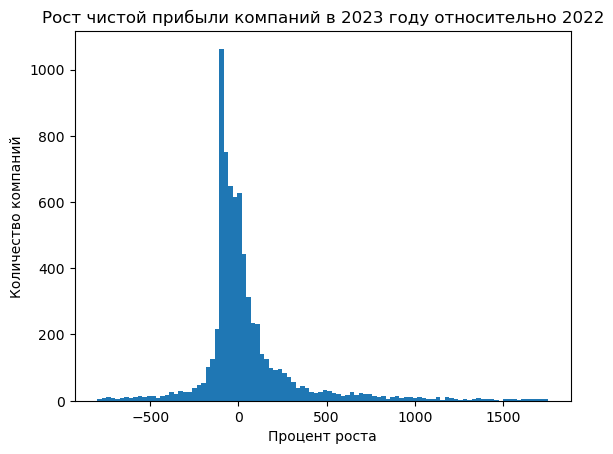

In [ ]:
plt.hist(increase_between_2022_2023,bins = 100)
plt.xlabel("Процент роста")
plt.ylabel("Количество компаний")
plt.title("Рост чистой прибыли компаний в 2023 году относительно 2022")
plt.show()

**Вывод:** О перспективности отрасли строительства судить трудно. С одной стороны, более чем у половины компаний наблюдается спад чистой прибыли за 2023 год. С другой стороны, c каждым годом мы видим рост средней EBITDA. В общем, вопрос требует дополнительного исследования.

##Топ-500 компаний по выручке на карте

In [ ]:
def get_coordinates(region_name):
    geolocator = Nominatim(user_agent="geoapiExercises")
    try:
        location = geolocator.geocode(region_name, timeout=10)
        time.sleep(1)
        if location:
            return (location.latitude, location.longitude)
        else:
            print(f"Не удалось найти координаты для: {region_name}")
            return (None, None)
    except Exception as e:
        print(f"Ошибка при обработке региона {region_name}: {e}")
        return (None, None)

In [ ]:
top_500_income, top_500_index = map(list,zip(*sorted(income_in_2023, key = lambda x: -x[0])[:500]))

In [ ]:
top_500_regions = filtered_registry.iloc[top_500_index]["Регион"]
top_500_regions = pd.Series([x[5:] for x in top_500_regions])
top_500_regions = (top_500_regions.replace("г.Москва", "Москва")
                   .replace("Чеченская Республика", "Чечня")
                   .replace("Волгоградская область", "Волгоград")
                   .replace("Ярославская область", "Ярославль")
                   .replace("Новосибирская область", "Новосибирск")
                   .replace("Московская область", "Московская область, Россия")
                   .replace("г.Санкт-Петербург", "Санкт-Петербург")
                   .replace("Республика Татарстан (Татарстан)", "Татарстан")
                   .replace("Пермский край", "Пермь")
                   .replace("Республика Мордовия", "Мордовия")
                   .replace("Свердловская область", "Екатеринбург")
                   .replace("Республика Ингушетия", "Ингушетия")
                   .replace("Саратовская область", "Саратов")
                   .replace("Нижегородская область", "Нижний Новгород")
                   .replace("Приморский край", "Владивосток")
                   .replace("Краснодарский край", "Краснодар")
                   .replace("Челябинская область", "Челябинск")
                   .replace("Чувашская Республика - Чувашия", "Чувашия")
                   .replace("Ямало-Ненецкий автономный округ", "Ямало-Ненецкий АО")
                   .replace("Белгородская область", "Белгород")
                   .replace("Воронежская область", "Воронеж")
                   .replace("Сахалинская область", "Южно-Сахалинск")
                   .replace("Амурская область", "Благовещенск")
                   .replace("Республика Крым", "Крым")
                   .replace("Калужская область", "Калуга")
                    .replace("Донецкая Народная Республика", "Донецк"))

In [ ]:
top_500_coordinates = [list(get_coordinates(region)) for region in top_500_regions]

In [ ]:
top_500_lat, top_500_lon = map(list, zip(*top_500_coordinates))

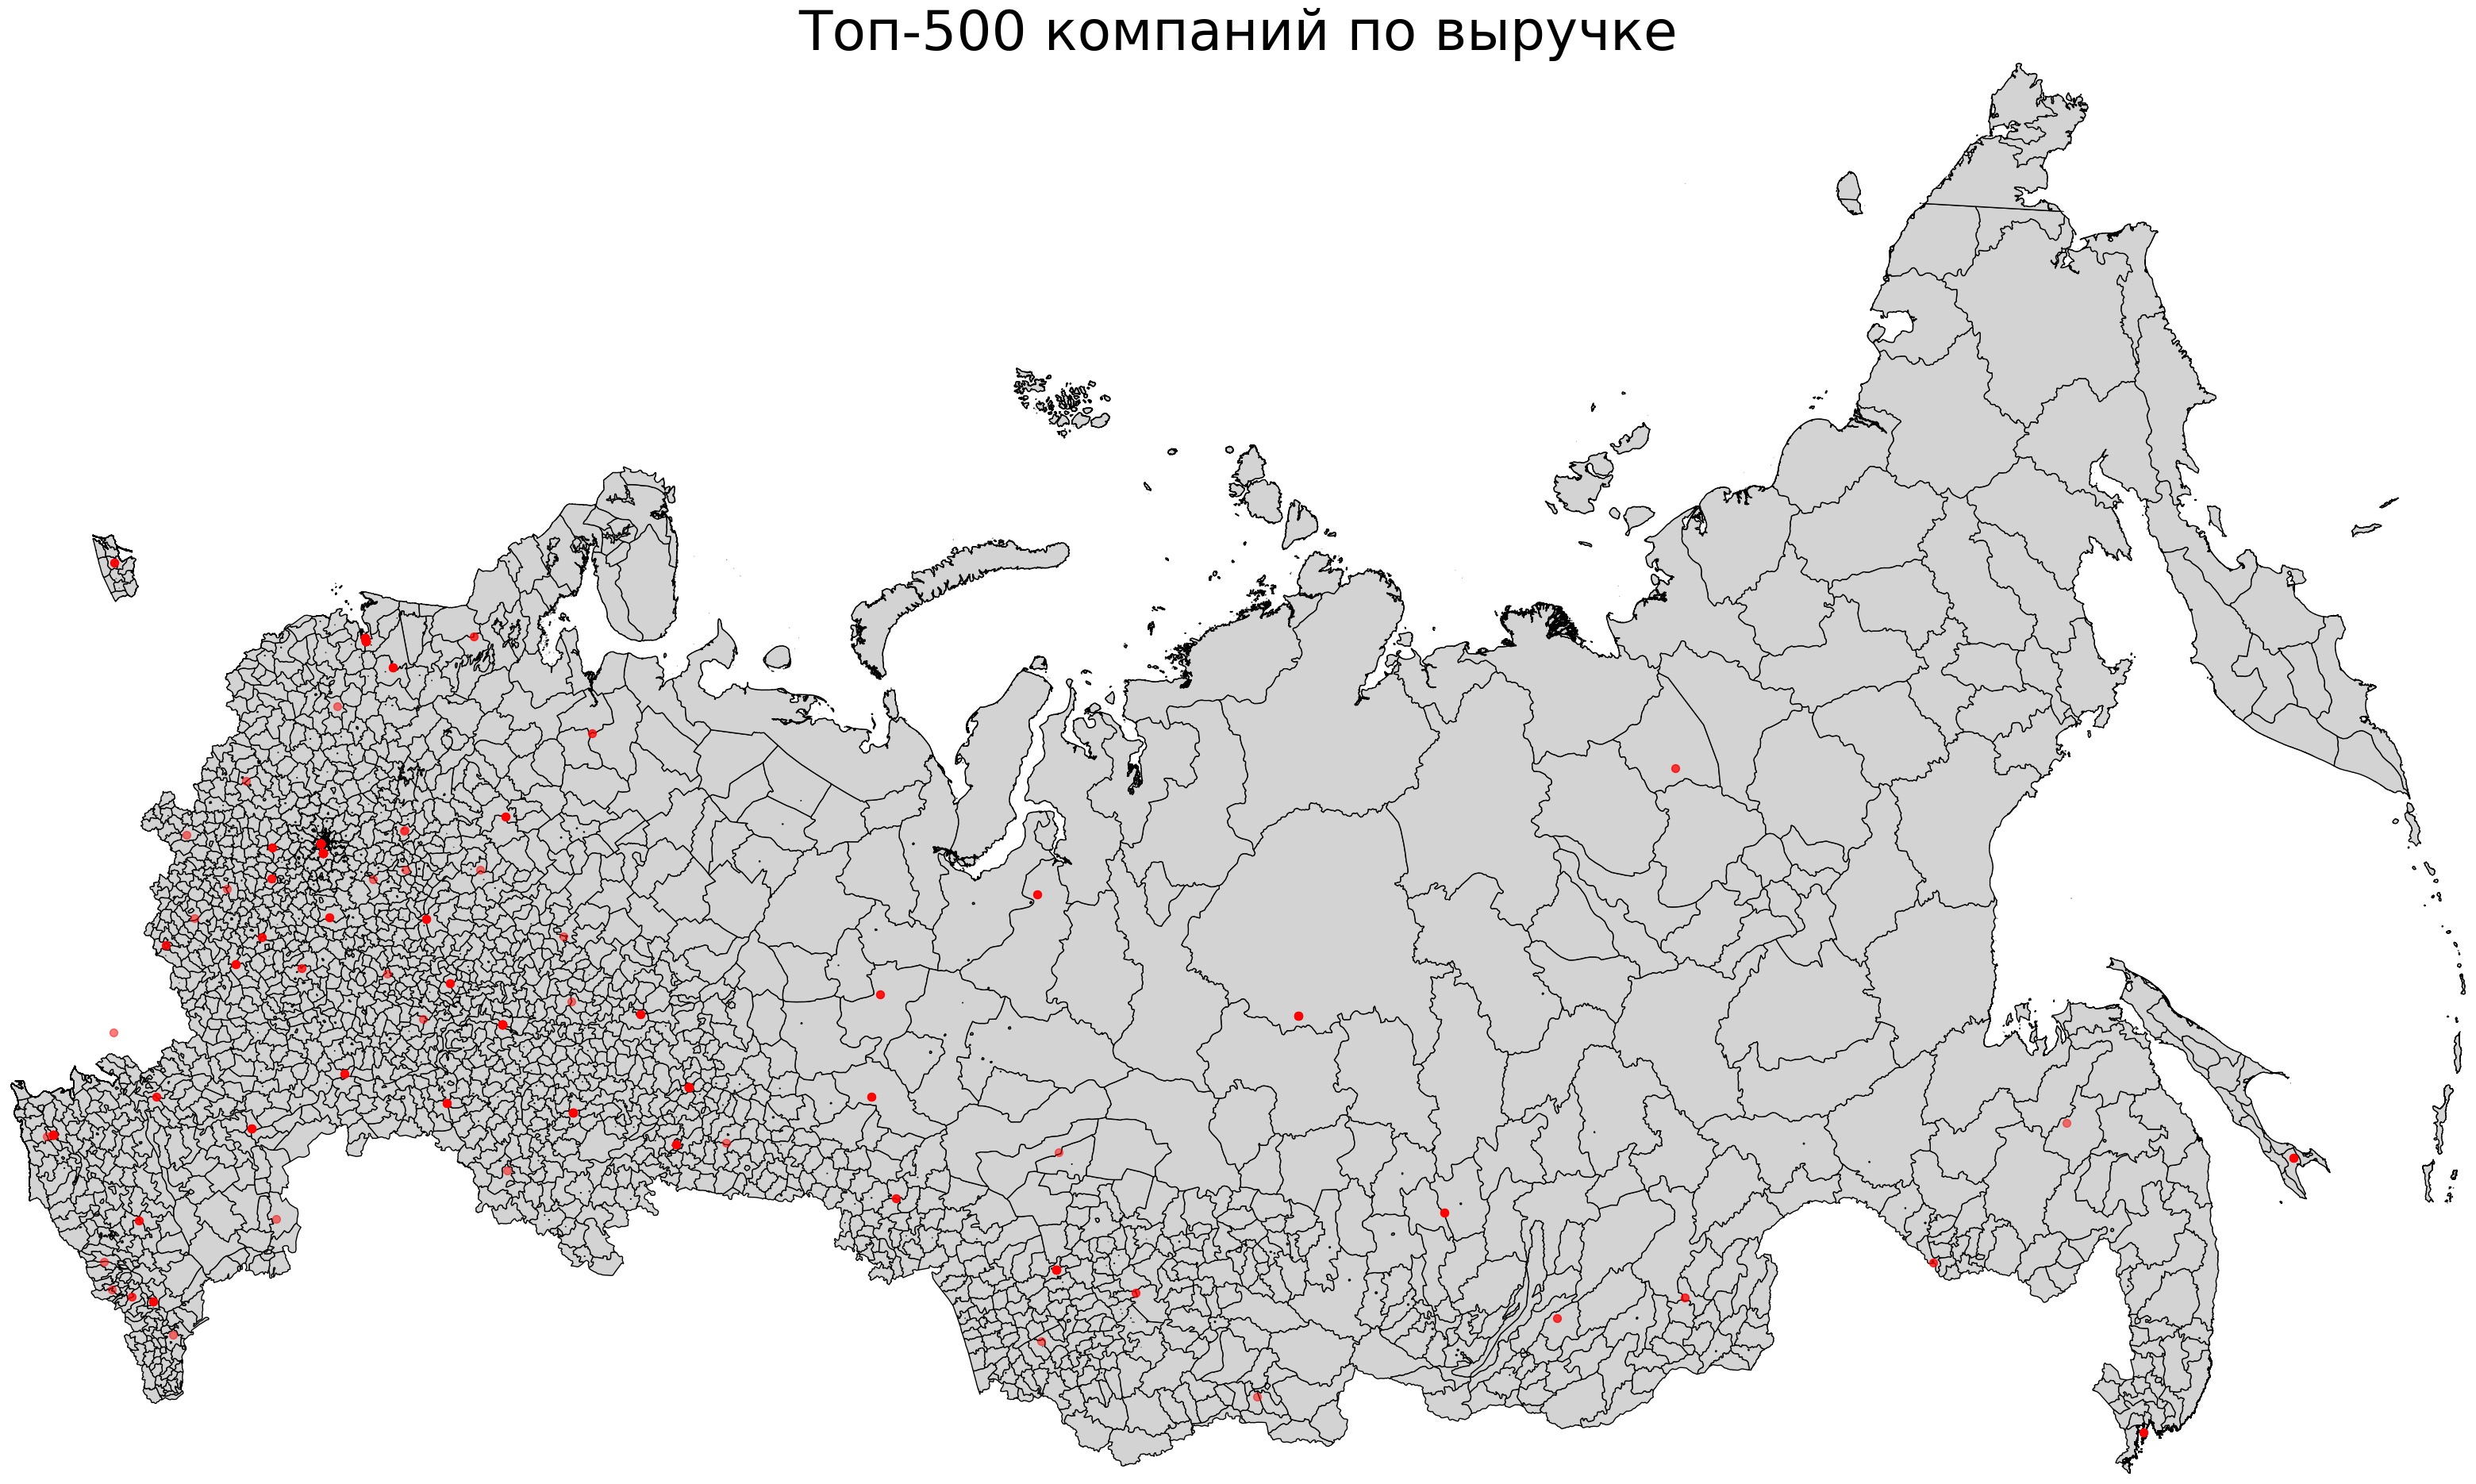

In [ ]:
geometry = [Point(xy) for xy in zip(top_500_lon, top_500_lat)]
gdf = gpd.GeoDataFrame(top_500_income, geometry=geometry, crs='EPSG:4326')


gdf = gdf.to_crs('EPSG:32646')


russia = gpd.read_file("gadm41_RUS_3.shp")


russia = russia.to_crs('EPSG:32646')


fig, ax = plt.subplots(figsize=(40, 40))


min_x, min_y, max_x, max_y = russia.total_bounds
ax.set_xlim([min_x - 10000, max_x + 10000])
ax.set_ylim([min_y - 10000, max_y + 10000])

ax.axis('off')


russia.plot(ax=ax, color="lightgrey", edgecolor="black")
gdf.plot(ax=ax, marker='o', color='red', markersize=50, alpha=0.5)

plt.title('Топ-500 компаний по выручке', fontsize=50)
plt.xlabel('X (метры)',fontsize=20)
plt.ylabel('Y (метры)', fontsize=20)
plt.show()